In [257]:
import pyodbc
import pandas as pd
import plotly.express as px

In [258]:
server              = 'localhost'
database            = 'US_AQI_DDS'  
username            = 'sa'  
password            = '123'
driver              = '{ODBC Driver 17 for SQL Server}'

In [259]:
connection_string = f"""
    DRIVER={driver};
    SERVER={server};
    DATABASE={database};
    UID={username};
    PWD={password};
    Trusted_Connection=yes;
"""

In [260]:
try:
    # Establish connection
    conn = pyodbc.connect(connection_string)
    print("Connection Successful!")
    
    # Create a cursor
    cursor = conn.cursor()
    
    query = f"""
        SELECT c.county_name, 
            s.state_name, 
            d.date, 
            f.aqi_value, 
            ca.level_of_concern, 
            ca.daily_aqi_color, 
            p.parameter_name
        FROM FACT_AIR_QUALITY f
        JOIN DIM_COUNTY c ON f.county_key=c.county_key
        JOIN DIM_STATE s ON s.state_key = c.state_key
        JOIN DIM_DATE d ON f.date_key = d.date_key
        JOIN DIM_CATEGORY ca ON ca.category_key = F.category_key
        JOIN DIM_PARAMETER p on p.parameter_key = f.defining_parameter_key
    """
    df = pd.read_sql_query(query, conn)
    print("Query Results:")
    print(df)

    cursor.close()
    conn.close()
except Exception as e:
    print("Error:", e)

Connection Successful!


C:\Users\win 10\AppData\Local\Temp\ipykernel_15044\2269626321.py:24: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Query Results:
                 county_name  state_name        date  aqi_value  \
0                 New Castle    Delaware  2023-03-26         35   
1                      Lucas        Ohio  2023-08-30         34   
2                    Trinity  California  2021-05-22         22   
3                    Kaufman       Texas  2022-12-05         36   
4                     Colusa  California  2023-03-24         38   
...                      ...         ...         ...        ...   
134894  Fairbanks North Star      Alaska  2021-01-08        169   
134895  Fairbanks North Star      Alaska  2021-01-01        189   
134896  Fairbanks North Star      Alaska  2021-01-27        163   
134897  Fairbanks North Star      Alaska  2021-01-09        174   
134898  Fairbanks North Star      Alaska  2021-01-13        163   

       level_of_concern daily_aqi_color parameter_name  
0                  Good           Green          Ozone  
1                  Good           Green          Ozone  
2        

In [261]:
df

,county_name,state_name,date,aqi_value,level_of_concern,daily_aqi_color,parameter_name
0,New Castle,Delaware,2023-03-26,35,Good,Green,Ozone
1,Lucas,Ohio,2023-08-30,34,Good,Green,Ozone
2,Trinity,California,2021-05-22,22,Good,Green,PM2.5
3,Kaufman,Texas,2022-12-05,36,Good,Green,PM2.5
4,Colusa,California,2023-03-24,38,Good,Green,Ozone
...,...,...,...,...,...,...,...
134894,Fairbanks North Star,Alaska,2021-01-08,169,Unhealthy,Red,PM2.5
134895,Fairbanks North Star,Alaska,2021-01-01,189,Unhealthy,Red,PM2.5
134896,Fairbanks North Star,Alaska,2021-01-27,163,Unhealthy,Red,PM2.5
134897,Fairbanks North Star,Alaska,2021-01-09,174,Unhealthy,Red,PM2.5


In [262]:
df['date'] = pd.to_datetime(df['date'])

In [263]:
df.describe()

,date,aqi_value
count,134899,134899.000000
mean,2022-04-10 01:55:42.153759232,44.031090
min,2021-01-01 00:00:00,0.000000
25%,2021-07-10 00:00:00,31.000000
50%,2022-02-01 00:00:00,41.000000
75%,2023-01-05 00:00:00,53.000000
max,2023-12-31 00:00:00,500.000000
std,NaN,23.318228


In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134899 entries, 0 to 134898
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   county_name       134899 non-null  object        
 1   state_name        134899 non-null  object        
 2   date              134899 non-null  datetime64[ns]
 3   aqi_value         134899 non-null  int64         
 4   level_of_concern  134899 non-null  object        
 5   daily_aqi_color   134899 non-null  object        
 6   parameter_name    134899 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 7.2+ MB


In [265]:
avg_aqi_df = df.groupby('date', as_index=False)['aqi_value'].mean()

In [266]:
fig = px.line(
    avg_aqi_df, 
    x='date', 
    y='aqi_value', 
    title='Average AQI Value by Date',
    labels={'aqi_value': 'Average AQI Value', 'date': 'Date'},
    line_shape='linear'
)
fig.show()

In [267]:
from statsmodels.tsa.stattools import adfuller 

adf = adfuller(avg_aqi_df['aqi_value'])

print(adf)
print('\nADF = ', str(adf[0])) #more towards negative value the better
print('\np-value = ', str(adf[1]))
print('\nCritical Values: ')

for key, val in adf[4].items(): #for loop to print the p-value (1%, 5% and 10%) and their respective values
    print(key,':',val)
    

    if adf[0] < val:
        print('Null Hypothesis Rejected. Time Series is Stationary')
    else:
        print('Null Hypothesis Accepted. Time Series is not Stationary')


(np.float64(-2.9365128514492276), np.float64(0.041263831050125946), 16, 1078, {'1%': np.float64(-3.4364306491488814), '5%': np.float64(-2.8642248442477976), '10%': np.float64(-2.5681995044075987)}, np.float64(5484.719641813863))

ADF =  -2.9365128514492276

p-value =  0.041263831050125946

Critical Values: 
1% : -3.4364306491488814
Null Hypothesis Accepted. Time Series is not Stationary
5% : -2.8642248442477976
Null Hypothesis Rejected. Time Series is Stationary
10% : -2.5681995044075987
Null Hypothesis Rejected. Time Series is Stationary


In [268]:
avg_aqi_df

,date,aqi_value
0,2021-01-01,50.345238
1,2021-01-02,43.559006
2,2021-01-03,46.493827
3,2021-01-04,44.745562
4,2021-01-05,46.509202
...,...,...
1090,2023-12-27,36.522727
1091,2023-12-28,37.538462
1092,2023-12-29,37.093023
1093,2023-12-30,39.584270


In [269]:
avg_aqi_df.set_index("date", inplace=True)

C:\Users\win 10\AppData\Local\Temp\ipykernel_15044\3655885854.py:7: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



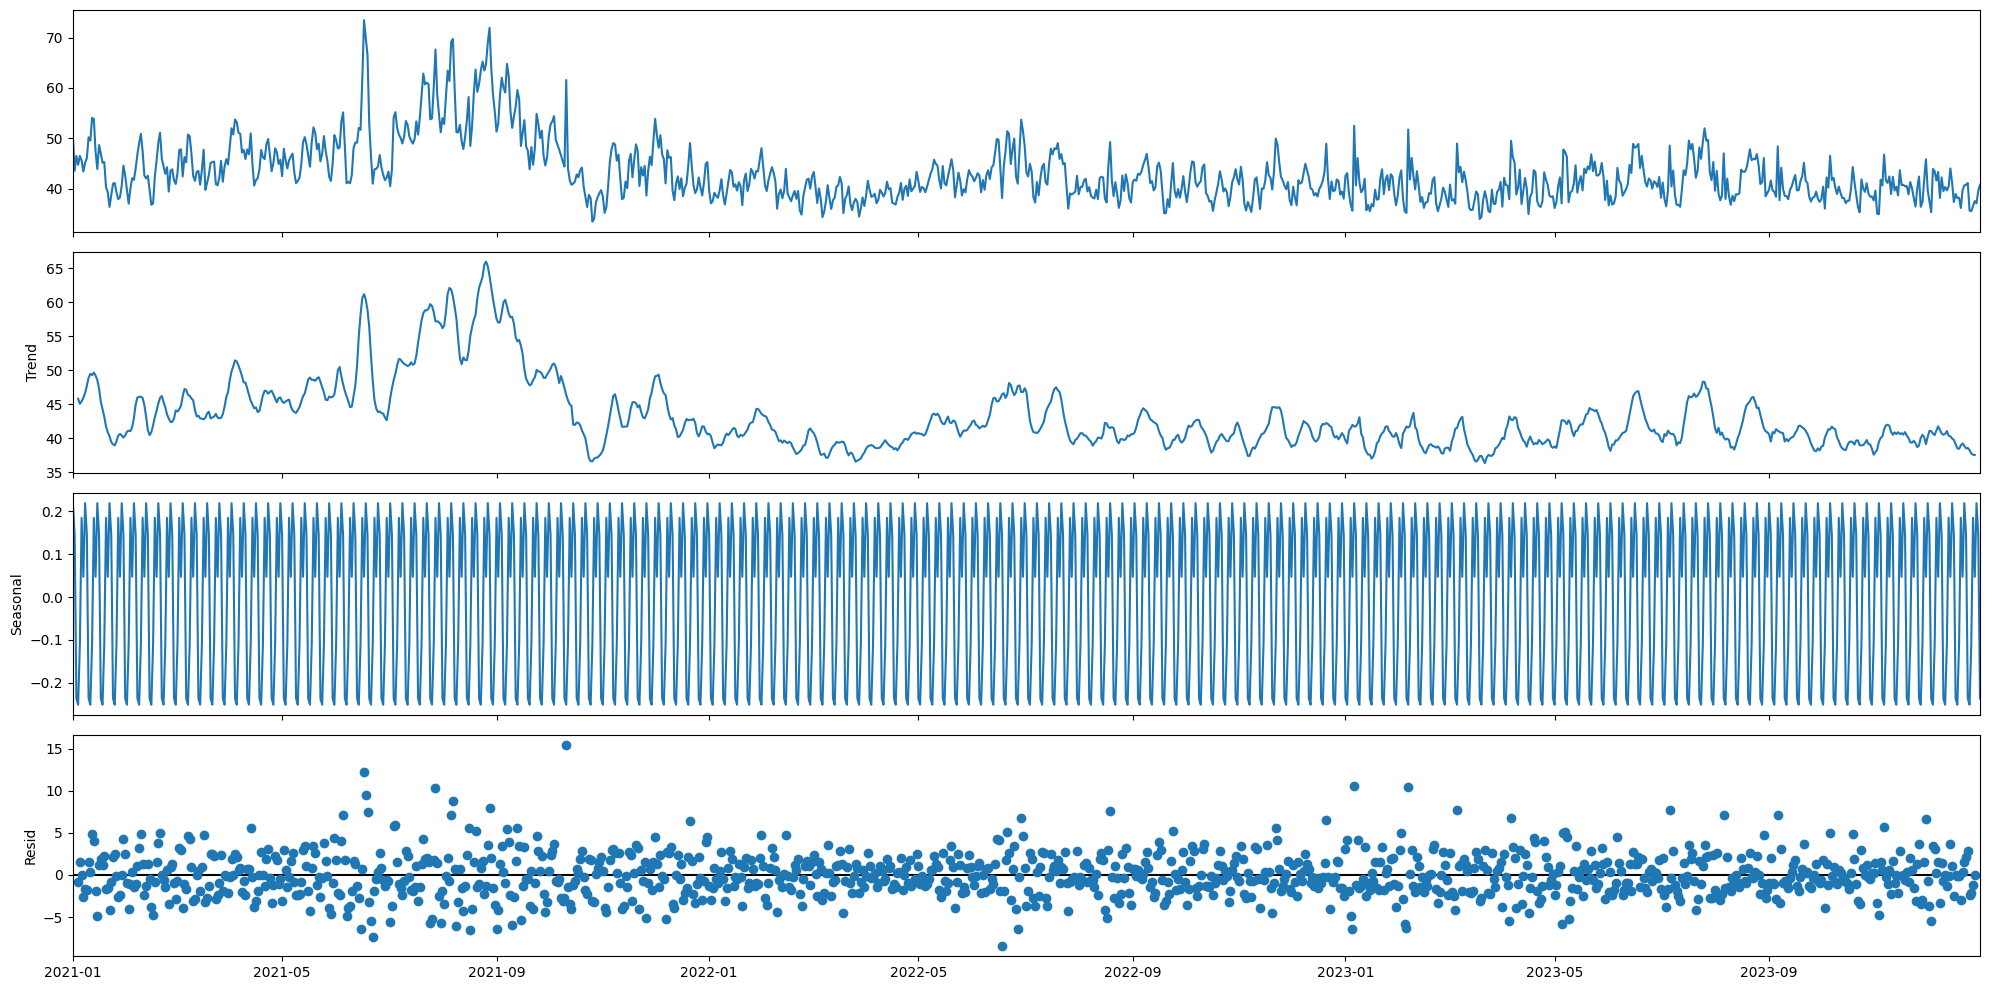

In [270]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(avg_aqi_df, model='additive')
fig = decomposition.plot()
fig.show()